In [21]:
import sys
import os

import numpy as np
import scipy as sp
import scipy.signal as sig

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cvxopt
import picos as pic


print (sys.version)
 
#sys.path.append("/Volumes/Macintosh\ HD/Applications/Gurobi\ 7.5.2.app/")
#pic.tools.available_solvers() 

2.7.14 |Anaconda custom (64-bit)| (default, Nov  8 2017, 16:45:25) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [22]:
#%%javascript
#MathJax.Hub.Config({
#      TeX: { equationNumbers: { autoNumber: "AMS" } }
#    });

# GPS Example

In this document we consider the the GPS configuration control example. GPS is modelled first capturing the discrete and continuous state and input signals via Mixed Integer Programming (MIP). We also use MIP to capture the constraints and objectives of the problem. Later we will consider a MPC scheme where the objective is do the programming in an online fashion by utilising a receeding horizon control.

## Offline Mixed Integer Programming 

### Modelling
 Consider a GPS represented by $D_1$, with the configuration $Conf_1=[u_{SkyAngle},u_{Power}]^{\top}$ where $u_{SkyAngle}$ represents the sky angle and $u_{Power}$ represents the on/off switch. The initial configuration at time $0$ is $Conf_1(0)=[10,1]$ meaning at the start the angle knob is located at $10$ degrees while the GPS is on.

 The state of the GPS, $S_1=[s_{NumSat},s_{Jam}]^{\top}$, consists of number of satellites represented by $s_{NumSat}$ and jammed state $s_{Jam}$ that are initially at $S_1(0)=[0,1]$ meaning that at the start the GPS has no satellites and is jammed (which is consistent with the fact that GPS does not see satellites when jammed). The following is model that captures the relationship between the configuration and state of the GPS.

The first model says that if GPS is not jammed it will remain unjammed in the next step.
\begin{equation}
s_{Jam}(t+1) <=  s_{Jam}(t)
\end{equation}

 The next equation models the fact (assumption) that in the next time step GPS is recovered from the jammed state(i.e. $s_{Jam}(t+1)=0$) if it is sequentially configured to `off` followed by `on` configuration in the previous two time steps (i.e. $u_{Power}(t)=1$ and $u_{Power}(t-1) =0$). If reset is not performed correctly then at least one of the multipliers of M is one, meaning that there is a very big number (M) on the right hand side of the inequality, which renders the inequality trivial and not active. In a way this is the mathematical one way of representing if-then conditions. 
\begin{equation}
s_{Jam}(t+1)\leq -2 + u_{Power}(t) + M*(1-u_{Power}(t)) + (1-u_{Power}(t-1))+ M*u_{Power}(t-1)
\end{equation}

If GPS is jammed ($s_{Jam}(t) = 1$) and the reset is not performed then the GPS will remain jammed ($s_{Jam}(t+1)=1$). This condition although straightforward needs 3 predicates to be checked. The first one is that GPS is currently jammed. Reset not performed predicate itself consists of the logical OR operation on 2 predicates the GPS power on/off configuration on the current time step $u_{Power}(t)$ and that of the previous time step $u_{Power}(t-1)$.    
Let us denote by $noreset(t) \in \{0,1\}$ the signal that captures whether reset has been performed correctly. The next two inequalities capture how it works. Note that $\epsilon>0$ is a very small number. One can verify by replacing the possible values for the variables to see that in fact the signal $noreset(t)=1$ captures when reset is not performed correctly. 
\begin{equation}
\begin{split}
&u_{Power}(t) - u_{Power}(t-1) <= (1 - noreset(t))\\
&u_{Power}(t) - u_{Power}(t-1) >= \epsilon + (-1 - \epsilon) * noreset(t)
\end{split}
\end{equation}

No we need to capture the logical AND condition of $noreset(t)$ and currently being jammed $s_{Jam}(t)$ which we represent via a new signal $jam_{noreset}(t)$. The following conditions govern the value of this signal. Again one can verify them by replacing values for the signals. 
\begin{equation}
\begin{split}
&-s_{Jam}(t) + jam_{noreset}(t) <= 0  \\
&-noreset(t) + jam_{noreset}(t)  <= 0\\
&s_{Jam}(t) + noreset(t) - jam_{noreset}(t)  <= 1  
\end{split}
\end{equation}
Next, we can now capture the original relationship stating that if GPS is jammed and not done reset ($jam_{noreset}(t)=1$ then the GPS will remain jammed ($s_{Jam}(t+1)=1$).
\begin{equation}
-s_{Jam}(t+1) + jam_{noreset}(t)  <= 0
\end{equation}

 The inequalities considered next captures how the number of satellites seen is affected by the jamming and sky angle configurations and the on/off status.
 Note that the disturbance $\vert d(t) \vert <2$ is not captured. Later on in the MPC section we show that the online feedback nature of MPC can deal with the disturbance by redoing the optimisation based on the feedback measured current state which is in fact subject to the disturbance $d$. We will provide an equation for how $d$ affects the actual number of satellites later in the MPC section. 
\begin{equation}
\begin{split}
& s_{NumSat}(t+1) <= s_{NumSat}(t) + \alpha * (u_{SkyAngle}(t-1) - u_{SkyAngle}(t)) \\
& s_{NumSat}(t+1)  \leq   M*u_{Power}(t)\\
& s_{NumSat}(t+1)  \leq   M* (1- s_{Jam}(t))\\
\end{split}
\end{equation}  

 Note that in case either the GPS is off, $ u_{Power}(t)=0$, or jammed,$s_{Jam}(t)=1$, the second or the third inequalities above force the number of satellites seen in the next step to zero. 
 
 Lastly we need equations that indicate to planner that playing with sky angle knob is useless when GPS is either off or in the jammed state.
\begin{equation}
\begin{split}
& \vert u_{SkyAngle}(t) - u_{SkyAngle}(t-1)\vert <= M * u_{Power}(t) \\ 
& \vert u_{SkyAngle}(t) - u_{SkyAngle}(t-1)\vert <= M * (1- s_{Jam}(t)) 
\end{split}
\end{equation}
 
  
 
 
 Next we solve this problem subject to the aforementioned constraints and numerical values specified for this problem. The problem is readily in a format appropriate for a MILP solver in Python called PICOS. 

Let us now create an instance prob of an optimization problem in PICOS



In [23]:
#create a Problem instance (note that picos was imported at the top of this notebook)
prob = pic.Problem()    

Let us define the state and control variable next. Before that we need to consider a horizen for the optimisation problem and a time step in order to determine the size of these variables.
Reference tutorial on PICOS : 
http://picos.zib.de/tuto.html#variables

In [24]:
T = 10 # seconds, the time horizon of optimisation 

In [25]:
dt = 1 #seconds, the time step of optimisation 

In [26]:
#size of the storage for all the values of different signals
# in the opt horizon and per step time (needs to be integer)
ssize = int(T/dt) 


Next we define the state variables


In [27]:
# num of sats per time step which is of type integer 
s_NumSat = prob.add_variable('s_NumSat', ssize, vtype = 'integer') 

In [28]:
#jammed/not jammed state per time step which is of type binary 
s_Jam = prob.add_variable('s_Jam', ssize, vtype = 'binary') 


Similarly, the control variables are given as


In [29]:
# sky angle knob per time step which is of type continuous
u_SkyAngle = prob.add_variable('u_SkyAngle', ssize, vtype = 'integer') 

In [30]:
# on/off knob per time step which is of type binary
u_Power = prob.add_variable('u_Power', ssize, vtype = 'binary') 


Adding inititial conditions:



Constraints can be added in the problem with the function add_constraint():


In [31]:
# num of satellites seen is above zero
prob.add_constraint( s_NumSat[:] >= 0)   
 # num of satellites seen is below 17
prob.add_constraint( s_NumSat[:] <= 17) 
# sky angle knob goes up only up to 10 degrees
prob.add_constraint( u_SkyAngle[:] <= 10)
# sky angle knob goes down only up to 0 degrees
prob.add_constraint( u_SkyAngle[:] >= 0)  
                             


Let us define some parameters (they are not variables and their values are provided by us).


In [32]:
# this is the big M notation and 100 seems a big enough number for now
M = 1000 


First equation says that we need to wait 3 steps before we can change the jammed state. Second equation says that if GPS is not jammed it will remain unjammed for the planning period. If GPS is jammed the 6th constraint equation details how by resetting the GPS in the previous two steps we will transition to the unjammed state. 


In [33]:
# first two values are jammed signal are not controllable
prob.add_constraint( s_Jam[1] == s_Jam[0] )


       
    
    

Next constraints captures how the number of satellites evolves in time albeit with some disturbance captures via the inequalities;

In [34]:
# this new binary variable captures if reset was not done correctly 
noreset = prob.add_variable ('noreset', ssize, vtype = 'binary')
prob.add_constraint( noreset[0] == 1) #noreset is initially active

epsilon = .2

# new variable to contain AND of being jammed
#in the previous step and not having done reset either
jam_noreset = prob.add_variable ('jam_noreset', ssize, vtype = 'binary')

#jam_noreset is initially based on whether GPS is jammed initially
prob.add_constraint( jam_noreset[0] == s_Jam[0]) 

for i in range (ssize-2):
    
    # if GPS is not jammed it will remain unjammed,
    # even after we have managed to get it out the jammed state
    prob.add_constraint( s_Jam[i+1] <=  s_Jam[i] )
    
    
 
    
    #equation relating sky angle to number of sats
    prob.add_constraint( s_NumSat[i+2] <= s_NumSat[i+1] + 1 * (u_SkyAngle[i] - u_SkyAngle[i+1]) )
    
    #equation saying GPS_off will kill the sats
    prob.add_constraint( s_NumSat[i] <= M * u_Power[i])

    #equation saying GPS_Jammed will kill the sats
    prob.add_constraint( s_NumSat[i] <= M * (1- s_Jam[i]))

    #equation saying don't be an idiot changing the sky angle if GPS is off or if it is jammed 
    prob.add_constraint (abs(u_SkyAngle[i+1] - u_SkyAngle[i]) <= M * u_Power[i+1] )  
    prob.add_constraint (abs(u_SkyAngle[i+1] - u_SkyAngle[i]) <= M * (1- s_Jam[i+1] ) )                    
    
    #equation saying how to reset GPS to get out of jammed state
    prob.add_constraint( s_Jam[i+2] <= -1  + u_Power[i+1] - u_Power[i]  + M * (1-u_Power[i+1]) + M * u_Power[i])
    
    
    
    # noreset variable update
    prob.add_constraint( u_Power[i+1] - u_Power[i] <= (1 - noreset[i+1]))
    prob.add_constraint( u_Power[i+1] - u_Power[i] >= epsilon + (-1 - epsilon) * noreset[i+1])
    
    
    # jammed and no reset variable update
    prob.add_constraint( -s_Jam[i+1] + jam_noreset[i+1] <= 0  ) 
    prob.add_constraint( -noreset[i+1] + jam_noreset[i+1]  <= 0  ) 
    prob.add_constraint( s_Jam[i+1] + noreset[i+1] - jam_noreset[i+1]  <= 1  ) 
    
    # if jammed and not done reset will remain jammed
    prob.add_constraint( -s_Jam[i+2] + jam_noreset[i+1]  <= 0  ) 
    
# these were not captured in the previous loop    
prob.add_constraint( s_NumSat[1] <= s_NumSat[0])
prob.add_constraint( s_Jam[ssize-1] <=  s_Jam[ssize-2] )

prob.add_constraint( s_NumSat[ssize-1] <= M * (1- s_Jam[ssize-1]))
prob.add_constraint( s_NumSat[ssize-2] <= M * (1- s_Jam[ssize-2]))

prob.add_constraint( s_NumSat[ssize-1] <=  M * u_Power[ssize-1] )
prob.add_constraint( s_NumSat[ssize-2] <=  M * u_Power[ssize-2] )

prob.add_constraint (abs(u_SkyAngle[ssize-1] - u_SkyAngle[ssize-2]) <= M * u_Power[ssize-1])
prob.add_constraint (abs(u_SkyAngle[ssize-1] - u_SkyAngle[ssize-2]) <= M * (1 - s_Jam[ssize-1]))                     


The base problem is to solve for state and control variables such that at the end there are more than 4 satellites.
The terminal constraint is added before that.


Adding initial conditions (constraints) as the last list of constraints so that we can easily find and replace them in the MPC later on:


In [35]:

prob.add_list_of_constraints([s_NumSat[0] == 0,
                              s_Jam[0] == 1,
                              u_Power[0] == 1,
                              u_SkyAngle[0] == 10],'initial conditions')


In [36]:


# note that the objective function is not trivial and needs to be crafted carefully
# The way it is now it is trying to push the system towards reference points:
# 8 for the sky angle because I want to minimise multipath errors
# and 8 for the number of satellites to position it well within having a fix.
# other noteworthy points: s_NumSat[-1] represents the numSats at end of horizon
# so I am putting extra penalty on that to make sure it is close to 8
# Also note that I am heavily penalising if the jammed state is not recovered in 3
# steps, which means the first two actions will make sure the GPS is off and then on
# I am telling it don't leave this for any later than the first thing that you do

ObjFunc = (-2* ((u_SkyAngle[1:ssize - 1] - 8)|(u_SkyAngle[1:ssize - 1] - 8))
            - 0 * (jam_noreset[1:ssize - 1]|1) - 3*((s_NumSat[2:ssize-1] - 8)|(s_NumSat[2:ssize-1] - 8))
            - 3 *((s_NumSat[-1]-8)|(s_NumSat[-1]-8)) - M * (s_Jam[2]|s_Jam[3]) )


prob.set_objective('max', ObjFunc )
print(prob)

---------------------
optimization problem  (MIQP):
60 variables, 177 affine constraints, 17 nnz  in 1 quad constraints

s_NumSat 	: (10, 1), integer
u_Power 	: (10, 1), binary
jam_noreset 	: (10, 1), binary
noreset 	: (10, 1), binary
s_Jam 	: (10, 1), binary
u_SkyAngle 	: (10, 1), integer

	maximize -2.0*(〈 u_SkyAngle[1:9] -|8.0| | u_SkyAngle[1:9] -|8.0| 〉) -0*〈 jam_noreset[1:9] | |1| 〉 -(3.0*(〈 s_NumSat[2:9] -|8.0| | s_NumSat[2:9] -|8.0| 〉)) -(3.0*(〈 s_NumSat[-1] -8.0 | s_NumSat[-1] -8.0 〉)) -1000.0*(〈 s_Jam[2] | s_Jam[3] 〉)
such that
  s_NumSat[:] > |0|
  s_NumSat[:] < |17.0|
  u_SkyAngle[:] < |10.0|
  u_SkyAngle[:] > |0|
  s_Jam[1] = s_Jam[0]
  noreset[0] = 1.0
  jam_noreset[0] = s_Jam[0]
  s_Jam[1] < s_Jam[0]
  s_NumSat[2] < s_NumSat[1] + 1.0*( u_SkyAngle[0] -u_SkyAngle[1] )
  s_NumSat[0] < 1000.0*u_Power[0]
  s_NumSat[0] < 1000.0*( -s_Jam[0] + 1.0 )
  ||u_SkyAngle[1] -u_SkyAngle[0]|| < 1000.0*u_Power[1]
  ||u_SkyAngle[1] -u_SkyAngle[0]|| < 1000.0*( -s_Jam[1] + 1.0 )
  s_Jam[2] < 

In [37]:
prob.solve(solver='gurobi',verbose=0)
# note that the optimisation problem is solved fast enough
# in 6 milliseconds!  

{'gurobi_model': <gurobi.Model MIP instance Unnamed: 177 constrs, 60 vars, Parameter changes: OptimalityTol=1e-08, BarQCPConvTol=1e-08, LogFile=gurobi.log, OutputFlag=0>,
 'obj': 1896.0,
 'status': 'OPTIMAL',
 'time': 0.0060651302337646484}

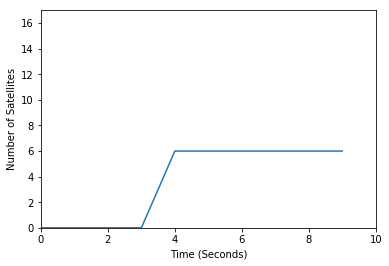

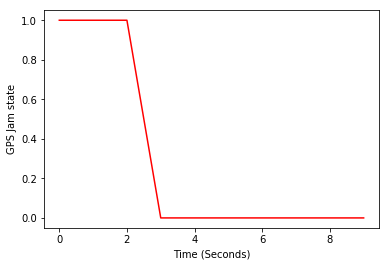

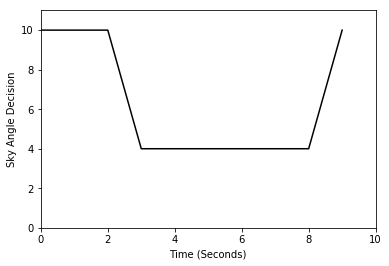

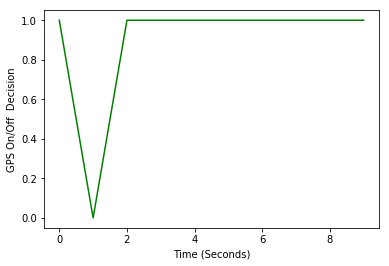

In [38]:
# Plotting the results

plt.plot(prob.get_valued_variable('s_NumSat'))
plt.ylabel('Number of Satellites')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, 0, 17])
plt.show()

plt.plot(prob.get_valued_variable('s_Jam'), 'r')
plt.ylabel('GPS Jam state')
plt.xlabel('Time (Seconds)')
plt.show()

plt.plot(prob.get_valued_variable('u_SkyAngle'), 'k')
plt.ylabel('Sky Angle Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, 0, 11])
plt.show()

plt.plot(prob.get_valued_variable('u_Power'), 'g')
plt.ylabel('GPS On/Off  Decision')
plt.xlabel('Time (Seconds)')
plt.show()


## The Model Perdictive Control  (MPC) Approach 

In this section we treat the bigger problem, by doing the previous optimisation at every time step in order to enable feedback control based on the current state and to build robustness with respect to the error in the actual number of satellites.  

We consider a simulation where the actual number of satellites is modelled by the following equations.
\begin{equation}\label{eq:transition}
\begin{split}
& s_{NumSat}(t+1) =  (s_{NumSat}(t) + \alpha (u_{SkyAngle}(t-1) - u_{SkyAngle}(t)) + d(t)) * (1-s_{Jam}(t)) * u_{Power}(t)\\
& d(t) \sim\mathcal{U}(-2,2) \\
& s_{Jam}(t) = \left\{\begin{array}{ll}1 & \mbox{if} \; s_{Jam}(t-1)=0\; \mbox{ AND}\; t =T_Sim/2\\
                                           0 & \mbox{if} \; u_{Power}(t-1)=1\; \mbox{ AND}\; u_{Power}(t-2)=0\\
                                           s_{Jam}(t-1) & \mbox{otherwise}\end{array}\right.     
\end{split}
\end{equation}
In this equation, at every time step the disturbance signals $d(t)$ affects the number of satellites while the planner has no model of how it affects the satellites.

In [39]:
# actual simulation time horizon 
T_Sim = 40

# size of the storage variables dt is the same as the time step for point optimisation
size_Sim = int (T_Sim/dt )

# the horizon for planning/optimisation
T_Opt = 5

# initialising the storage array for the variables of the problem
s_NumSat_Sim = [0] * size_Sim
s_NumSat_Sim_0  = 0
s_NumSat_Sim[0] = s_NumSat_Sim_0
s_NumSat_Sim[1] = s_NumSat_Sim_0


s_NumSat_Plan = [0] * size_Sim
s_NumSat_Plan_0  = 0
s_NumSat_Plan[0] = s_NumSat_Plan_0
s_NumSat_Plan[1] = s_NumSat_Plan_0

s_Jam_Sim = [0] * size_Sim
s_Jam_Sim_0 = 1
s_Jam_Sim[0] = s_Jam_Sim_0
s_Jam_Sim[1] = s_Jam_Sim_0


s_Jam_Plan = [0] * size_Sim
s_Jam_Plan_0 = 1
s_Jam_Plan[0] = s_Jam_Plan_0
s_Jam_Plan[1] = s_Jam_Plan_0



u_Power_Sim = [0] * size_Sim
u_Power_Sim_0 = 1
u_Power_Sim[0] = u_Power_Sim_0


u_SkyAngle_Sim = [0] * size_Sim
u_SkyAngle_Sim_0 = 10
u_SkyAngle_Sim[0] = u_SkyAngle_Sim_0



    
# this is the main loop of the simulation 
i = 0
while (i <= size_Sim - T_Opt - 2):
    
    
    # reset the variables of the solver
    prob.reset_gurobi_instance()
    
    # remove the initial conditions for the solver
    prob.remove_constraint((-1,))
    
    
    

    # add the updated states and variables for the initial conditions of the solver
    prob.add_list_of_constraints([s_NumSat[0] == s_NumSat_Sim[i],
                              s_Jam[0] == s_Jam_Sim[i],
                              u_Power[0] == u_Power_Sim[i],
                              u_SkyAngle[0] == u_SkyAngle_Sim[i]],'initial conditions')
    
    #solve for the next N steps
    prob.solve(solver='gurobi',verbose=0)
    
    # this is the execution loop of the simulation in which for T_Opt steps
    # the plan of the planner is applied to the GPS configurations
    for j in range (T_Opt):
        
        
        #reading the plan from the solver for two steps
        u_SkyAngle_Sim[i+j] = int (prob.get_valued_variable ('u_SkyAngle')[j])
        u_Power_Sim[i+j] = int(prob.get_valued_variable ('u_Power')[j])
        
        u_SkyAngle_Sim[i+j+1] = int(prob.get_valued_variable ('u_SkyAngle')[j+1])
        u_Power_Sim[i+j+1] = int(prob.get_valued_variable ('u_Power')[j+1])

        
        #disturbance signal randint returns uniformly probable an integer between [lower upper) upper not included.  
        d = np.random.randint(-2,3) 
        
    
        
        # how the jam state is decided
        nextJam = 0
        
        if (s_Jam_Sim[i + j+1]==0 and  (i + j+1) == size_Sim/2 ):
            nextJam=1
        elif ( u_Power_Sim[i+j+1]==1 and u_Power_Sim[i+j]==0 ):
            nextJam = 0
        else :
            nextJam = s_Jam_Sim[i+j+1]
        s_Jam_Sim[i+j+2] = nextJam
        
        
        # how the actual number of satellites is decided 
        s_NumSat_Sim[i+j+2] = int((abs((s_NumSat_Sim[i+j+1] + u_SkyAngle_Sim[i+j] - u_SkyAngle_Sim[i+j+1] + d)) * (1-s_Jam_Sim[i+j+1]) * u_Power_Sim[i+j+1]))
        
        # storing what the planner had predicted for the states
        s_NumSat_Plan[i+j+2] = int(prob.get_valued_variable ('s_NumSat')[j+2])
        s_Jam_Plan[i+j+2] = int(prob.get_valued_variable ('s_Jam')[j+2])
    
    # house keeping for the interplay of the inner and outer loop (you can ignore these)
    i = i + T_Opt + 1    
    u_Power_Sim[i] = u_Power_Sim[i - 1]
    u_SkyAngle_Sim[i] = u_SkyAngle_Sim[i - 1]
    s_NumSat_Sim[i+1] = s_NumSat_Sim[i]
    s_Jam_Sim[i+1] = s_Jam_Sim[i]
    s_NumSat_Plan [i+1] = s_NumSat_Plan [i] 
    s_Jam_Plan[i+1] = s_Jam_Plan[i]



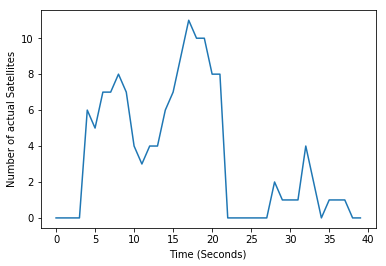

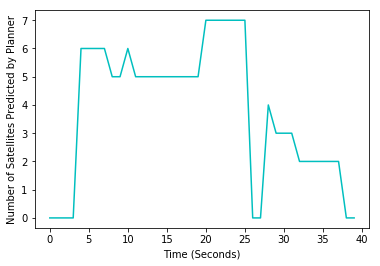

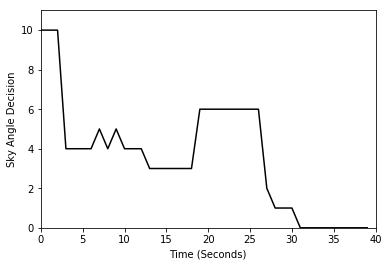

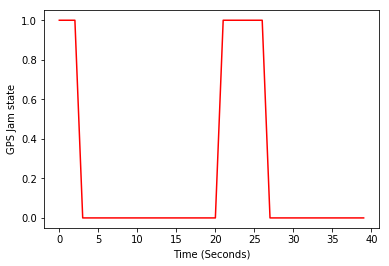

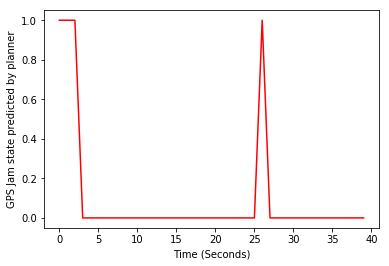

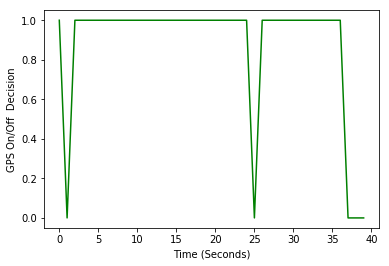

In [40]:
# Plotting the results
plt.plot(s_NumSat_Sim)
plt.ylabel('Number of actual Satellites')
plt.xlabel('Time (Seconds)')
#plt.axis([0, size_Sim, 0, 17])
plt.show()

plt.plot(s_NumSat_Plan,'c')
plt.ylabel('Number of Satellites Predicted by Planner')
plt.xlabel('Time (Seconds)')
#plt.axis([0, size_Sim, 0, 17])
plt.show()

plt.plot(u_SkyAngle_Sim, 'k')
plt.ylabel('Sky Angle Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, 0, 11])
plt.show()

plt.plot(s_Jam_Sim, 'r')
plt.ylabel('GPS Jam state')
plt.xlabel('Time (Seconds)')
plt.show()

plt.plot(s_Jam_Plan, 'r')
plt.ylabel('GPS Jam state predicted by planner')
plt.xlabel('Time (Seconds)')
plt.show()

plt.plot(u_Power_Sim, 'g')
plt.ylabel('GPS On/Off  Decision')
plt.xlabel('Time (Seconds)')
plt.show()


## 